In [1]:
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 1
%aimport CodingFeatures
%aimport CodingTransformers

In [2]:
# get annotated protein sequences
annotated = pd.read_csv('../data/BW25113proteome_dnaseq.csv') # get full sheet
annotated = annotated.drop_duplicates('seq').dropna() # drop duplicated proteins and missing DNA_seq
annotated['DNA_seq'] = annotated['DNA_seq'].apply(lambda x: x[3:]) # trim start codons from DNA_seq
annotated['start'] = annotated['start'] + 3 # increment sequence location index

training_data = annotated.loc[:,['DNA_seq','start']] # get sequence, location index
training_data['label'] = True # label

In [3]:
from CodingFeatures import codon_lookup

codon_table, c_lookup = codon_lookup()
AA_list = codon_table['aa'].unique()[1:]

In [4]:
import random
import re

# generate negative training set
acid_bag = list(zip(codon_table.index[3:],codon_table.f_tot[3:])) # zip AAs and total frequencies
acid_bag = [[x[0]]*int(x[1]*10000) for x in acid_bag] # expand AAs by frequencies
acid_bag = [x for X in acid_bag for x in X] # flatten list
# random.seed(23)
random.shuffle(acid_bag) # pseudo-randomize
stop_bag = ['TAA','TAA','TAA','TAA','TAA','TAA','TAG','TGA','TGA','TGA']

seq_random = []
# generate randomized sequences matching annotated lengths with known whole-genome codon biases
for L in annotated.length:
    tmp = [random.choice(acid_bag) for x in range(L-1)] + [random.choice(stop_bag)]
    seq_random.append(''.join(tmp))

Axes(0.125,0.125;0.775x0.775)
Axes(0.125,0.125;0.775x0.775)


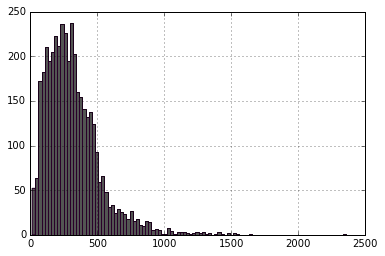

In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# check length distributions
print(annotated.length.hist(bins=100, color='green'))
print(pd.Series(map(lambda x: len(x)/3,seq_random)).hist(bins=100,color='magenta',alpha=.33))

In [6]:
# reformat negative training set, label
training_random = pd.DataFrame(seq_random, columns=['DNA_seq'])
training_random['start'] = 0
training_random['label'] = False
# append to training_data
training_data = training_data.append(training_random, ignore_index=True)

In [7]:
from sklearn.cross_validation import train_test_split

train, test = train_test_split(training_data, train_size=.8, random_state=17)

In [8]:
from CodingFeatures import DNAFeatureExtraction, fragment_stop_delimited, fragment_windowed

train_object = DNAFeatureExtraction(list(train.DNA_seq), list_indices=list(train.start)).decode_dna(c_lookup)
test_object = DNAFeatureExtraction(list(test.DNA_seq), list_indices=list(test.start)).decode_dna(c_lookup)

In [9]:
from CodingFeatures import zerocross_pack, codon_bias_rms, aa_pack, class_pack, statpack1, statpack2
from CodingTransformers import ArrayFunctionTransformer
import sklearn as sk
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier as RCF
from sklearn.grid_search import GridSearchCV

In [12]:
pipe = Pipeline([
        ('features', FeatureUnion([
                    ('aromatic', ArrayFunctionTransformer(statpack1,'aa_aromatic')),
                    ('classes', ArrayFunctionTransformer(class_pack, 'aa_class')),
                    ('hydro_z', ArrayFunctionTransformer(zerocross_pack, 'aa_hydrophob')),
                    ('hydro_s', ArrayFunctionTransformer(statpack1, 'aa_hydrophob')),
                    ('c_prefs', ArrayFunctionTransformer(statpack1, 'codon_pref')),
                    ('c_bias', ArrayFunctionTransformer(codon_bias_rms, 'fragments', params=(c_lookup, AA_list))),
                    ('aa_pack', ArrayFunctionTransformer(aa_pack, 'peptides', params=(AA_list,)))
                ])),
        ('estimator', RCF(random_state=17,n_jobs=1))
    ])

In [15]:
model = pipe.fit(train_object, list(train.label))

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/pmclean/anaconda/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
/Users/pmclean/anaconda/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x101ba2390, file "/Use...3.5/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/pmclean/anaconda/lib/python3.5/site-packages/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/Users/pmclean/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/pmcle.../python3.5/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x101ba2390, file "/Use...3.5/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/pmclean/anaconda/lib/python3.5/site-packages/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/Users/pmclean/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/pmcle.../python3.5/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/pmclean/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/Users/pmclean/anaconda/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    591         
    592         If a global instance already exists, this reinitializes and starts it
    593         """
    594         app = cls.instance(**kwargs)
    595         app.initialize(argv)
--> 596         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    597 
    598 #-----------------------------------------------------------------------------
    599 # utility functions, for convenience
    600 #-----------------------------------------------------------------------------

...........................................................................
/Users/pmclean/anaconda/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    437         
    438         if self.poller is not None:
    439             self.poller.start()
    440         self.kernel.start()
    441         try:
--> 442             ioloop.IOLoop.instance().start()
    443         except KeyboardInterrupt:
    444             pass
    445 
    446 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/pmclean/anaconda/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    157             PollIOLoop.configure(ZMQIOLoop)
    158         return PollIOLoop.current(*args, **kwargs)
    159     
    160     def start(self):
    161         try:
--> 162             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    163         except ZMQError as e:
    164             if e.errno == ETERM:
    165                 # quietly return on ETERM
    166                 pass

...........................................................................
/Users/pmclean/anaconda/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
/Users/pmclean/anaconda/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/pmclean/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/pmclean/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/pmclean/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/pmclean/anaconda/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/pmclean/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/pmclean/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'model = pipe.fit(train_object, list(train.label))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-08-12T16:53:41.820795', 'msg_id': '0A916317BB2742A7A5915887AA2F931C', 'msg_type': 'execute_request', 'session': '32CBB9E2441F45BC9BD92063F04C8332', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '0A916317BB2742A7A5915887AA2F931C', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'32CBB9E2441F45BC9BD92063F04C8332']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'model = pipe.fit(train_object, list(train.label))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-08-12T16:53:41.820795', 'msg_id': '0A916317BB2742A7A5915887AA2F931C', 'msg_type': 'execute_request', 'session': '32CBB9E2441F45BC9BD92063F04C8332', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '0A916317BB2742A7A5915887AA2F931C', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/Users/pmclean/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'32CBB9E2441F45BC9BD92063F04C8332'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'model = pipe.fit(train_object, list(train.label))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-08-12T16:53:41.820795', 'msg_id': '0A916317BB2742A7A5915887AA2F931C', 'msg_type': 'execute_request', 'session': '32CBB9E2441F45BC9BD92063F04C8332', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '0A916317BB2742A7A5915887AA2F931C', 'msg_type': 'execute_request', 'parent_header': {}})
    386         if not silent:
    387             self.execution_count += 1
    388             self._publish_execute_input(code, parent, self.execution_count)
    389 
    390         reply_content = self.do_execute(code, silent, store_history,
--> 391                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    392 
    393         # Flush output before sending the reply.
    394         sys.stdout.flush()
    395         sys.stderr.flush()

...........................................................................
/Users/pmclean/anaconda/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='model = pipe.fit(train_object, list(train.label))', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    194 
    195         reply_content = {}
    196         # FIXME: the shell calls the exception handler itself.
    197         shell._reply_content = None
    198         try:
--> 199             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method InteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'model = pipe.fit(train_object, list(train.label))'
        store_history = True
        silent = False
    200         except:
    201             status = u'error'
    202             # FIXME: this code right now isn't being used yet by default,
    203             # because the run_cell() call above directly fires off exception

...........................................................................
/Users/pmclean/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='model = pipe.fit(train_object, list(train.label))', store_history=True, silent=False, shell_futures=True)
   2700                 self.displayhook.exec_result = result
   2701 
   2702                 # Execute the user code
   2703                 interactivity = "none" if silent else self.ast_node_interactivity
   2704                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2705                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2706                 
   2707                 self.last_execution_succeeded = not has_raised
   2708 
   2709                 # Reset this so later displayed values do not modify the

...........................................................................
/Users/pmclean/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>], cell_name='<ipython-input-15-c2175e3c50bd>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 11c464ef0, execution_..._before_exec=None error_in_exec=None result=None>)
   2804 
   2805         try:
   2806             for i, node in enumerate(to_run_exec):
   2807                 mod = ast.Module([node])
   2808                 code = compiler(mod, cell_name, "exec")
-> 2809                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x11dd3cb70, file "<ipython-input-15-c2175e3c50bd>", line 1>
        result = <ExecutionResult object at 11c464ef0, execution_..._before_exec=None error_in_exec=None result=None>
   2810                     return True
   2811 
   2812             for i, node in enumerate(to_run_interactive):
   2813                 mod = ast.Interactive([node])

...........................................................................
/Users/pmclean/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x11dd3cb70, file "<ipython-input-15-c2175e3c50bd>", line 1>, result=<ExecutionResult object at 11c464ef0, execution_..._before_exec=None error_in_exec=None result=None>)
   2864         outflag = 1  # happens in more places, so it's easier as default
   2865         try:
   2866             try:
   2867                 self.hooks.pre_run_code_hook()
   2868                 #rprint('Running code', repr(code_obj)) # dbg
-> 2869                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x11dd3cb70, file "<ipython-input-15-c2175e3c50bd>", line 1>
        self.user_global_ns = {'AA_list': array(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', '...'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], dtype=object), 'ArrayFunctionTransformer': <class '__main__.ArrayFunctionTransformer'>, 'CodingFeatures': <module 'CodingFeatures' from '/Users/pmclean/Google Drive/ShadowProteome/src/CodingFeatures.py'>, 'CodingTransformers': <module 'CodingTransformers' from '/Users/pmclea... Drive/ShadowProteome/src/CodingTransformers.py'>, 'DNAFeatureExtraction': <class 'CodingFeatures.DNAFeatureExtraction'>, 'FeatureUnion': <class 'sklearn.pipeline.FeatureUnion'>, 'GridSearchCV': <class 'sklearn.grid_search.GridSearchCV'>, 'In': ['', "import numpy as np\nimport pandas as pd\n\nget_ipyt...get_ipython().magic('aimport CodingTransformers')", "# get annotated protein sequences\nannotated = pd...ation index\ntraining_data['label'] = True # label", "from CodingFeatures import codon_lookup\n\ncodon_t...lookup()\nAA_list = codon_table['aa'].unique()[1:]", "import random\nimport re\n\n# generate negative tra...ce(stop_bag)]\n    seq_random.append(''.join(tmp))", "import matplotlib\nimport matplotlib.pyplot as pl...andom)).hist(bins=100,color='magenta',alpha=.33))", '# reformat negative training set, label\ntraining...g_data.append(training_random, ignore_index=True)', 'from sklearn.cross_validation import train_test_...it(training_data, train_size=.8, random_state=17)', 'from CodingFeatures import DNAFeatureExtraction,...st_indices=list(test.start)).decode_dna(c_lookup)', 'from CodingFeatures import zerocross_pack, codon... RCF\nfrom sklearn.grid_search import GridSearchCV', 'class ArrayFunctionTransformer(sk.base.BaseEstim...arams else ()))\n        return np.asarray(result)', "pipe = Pipeline([\n        ('features', FeatureUn...estimator', RCF(random_state=17,n_jobs=1))\n    ])", "pipe = Pipeline([\n        ('features', FeatureUn...stimator', RCF(random_state=17,n_jobs=-1))\n    ])", 'model = pipe.fit(train_object, list(train.labels))', 'train', 'model = pipe.fit(train_object, list(train.label))'], 'L': 648, 'Out': {14:                                                 ...aag...  1811395.0   True

[6545 rows x 3 columns]}, ...}
        self.user_ns = {'AA_list': array(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', '...'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], dtype=object), 'ArrayFunctionTransformer': <class '__main__.ArrayFunctionTransformer'>, 'CodingFeatures': <module 'CodingFeatures' from '/Users/pmclean/Google Drive/ShadowProteome/src/CodingFeatures.py'>, 'CodingTransformers': <module 'CodingTransformers' from '/Users/pmclea... Drive/ShadowProteome/src/CodingTransformers.py'>, 'DNAFeatureExtraction': <class 'CodingFeatures.DNAFeatureExtraction'>, 'FeatureUnion': <class 'sklearn.pipeline.FeatureUnion'>, 'GridSearchCV': <class 'sklearn.grid_search.GridSearchCV'>, 'In': ['', "import numpy as np\nimport pandas as pd\n\nget_ipyt...get_ipython().magic('aimport CodingTransformers')", "# get annotated protein sequences\nannotated = pd...ation index\ntraining_data['label'] = True # label", "from CodingFeatures import codon_lookup\n\ncodon_t...lookup()\nAA_list = codon_table['aa'].unique()[1:]", "import random\nimport re\n\n# generate negative tra...ce(stop_bag)]\n    seq_random.append(''.join(tmp))", "import matplotlib\nimport matplotlib.pyplot as pl...andom)).hist(bins=100,color='magenta',alpha=.33))", '# reformat negative training set, label\ntraining...g_data.append(training_random, ignore_index=True)', 'from sklearn.cross_validation import train_test_...it(training_data, train_size=.8, random_state=17)', 'from CodingFeatures import DNAFeatureExtraction,...st_indices=list(test.start)).decode_dna(c_lookup)', 'from CodingFeatures import zerocross_pack, codon... RCF\nfrom sklearn.grid_search import GridSearchCV', 'class ArrayFunctionTransformer(sk.base.BaseEstim...arams else ()))\n        return np.asarray(result)', "pipe = Pipeline([\n        ('features', FeatureUn...estimator', RCF(random_state=17,n_jobs=1))\n    ])", "pipe = Pipeline([\n        ('features', FeatureUn...stimator', RCF(random_state=17,n_jobs=-1))\n    ])", 'model = pipe.fit(train_object, list(train.labels))', 'train', 'model = pipe.fit(train_object, list(train.label))'], 'L': 648, 'Out': {14:                                                 ...aag...  1811395.0   True

[6545 rows x 3 columns]}, ...}
   2870             finally:
   2871                 # Reset our crash handler in place
   2872                 sys.excepthook = old_excepthook
   2873         except SystemExit as e:

...........................................................................
/Users/pmclean/Google Drive/ShadowProteome/src/<ipython-input-15-c2175e3c50bd> in <module>()
----> 1 
      2 
      3 
      4 
      5 
      6 model = pipe.fit(train_object, list(train.label))
      7 
      8 
      9 
     10 

...........................................................................
/Users/pmclean/anaconda/lib/python3.5/site-packages/sklearn/pipeline.py in fit(self=Pipeline(steps=[('features', FeatureUnion(n_jobs... random_state=17, verbose=0, warm_start=False))]), X=<CodingFeatures.DNAFeatureExtraction object>, y=[True, False, False, False, True, False, True, True, False, False, True, True, True, True, True, True, True, True, True, True, ...], **fit_params={})
    160         y : iterable, default=None
    161             Training targets. Must fulfill label requirements for all steps of
    162             the pipeline.
    163         """
    164         Xt, fit_params = self._pre_transform(X, y, **fit_params)
--> 165         self.steps[-1][-1].fit(Xt, y, **fit_params)
        self.steps.fit = undefined
        Xt = array([[  0.12      ,   0.32496154,   0.        ...0.        ,
          6.        ,  24.        ]])
        y = [True, False, False, False, True, False, True, True, False, False, True, True, True, True, True, True, True, True, True, True, ...]
        fit_params = {}
    166         return self
    167 
    168     def fit_transform(self, X, y=None, **fit_params):
    169         """Fit all the transforms one after the other and transform the

...........................................................................
/Users/pmclean/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py in fit(self=RandomForestClassifier(bootstrap=True, class_wei...se, random_state=17, verbose=0, warm_start=False), X=array([[  0.12      ,   0.32496154,   0.        ...       6.        ,  24.        ]], dtype=float32), y=array([[ 1.],
       [ 0.],
       [ 0.],
       ..., 
       [ 1.],
       [ 0.],
       [ 1.]]), sample_weight=None)
    285             trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
    286                              backend="threading")(
    287                 delayed(_parallel_build_trees)(
    288                     t, self, X, y, sample_weight, i, len(trees),
    289                     verbose=self.verbose, class_weight=self.class_weight)
--> 290                 for i, t in enumerate(trees))
        i = 9
    291 
    292             # Collect newly grown trees
    293             self.estimators_.extend(trees)
    294 

...........................................................................
/Users/pmclean/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseForest.fit.<locals>.<genexpr>>)
    805             if pre_dispatch == "all" or n_jobs == 1:
    806                 # The iterable was consumed all at once by the above for loop.
    807                 # No need to wait for async callbacks to trigger to
    808                 # consumption.
    809                 self._iterating = False
--> 810             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    811             # Make sure that we get a last message telling us we are done
    812             elapsed_time = time.time() - self._start_time
    813             self._print('Done %3i out of %3i | elapsed: %s finished',
    814                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Fri Aug 12 17:03:48 2016
PID: 53787                 Python 3.5.2: /Users/pmclean/anaconda/bin/python
...........................................................................
/Users/pmclean/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
     67     def __init__(self, iterator_slice):
     68         self.items = list(iterator_slice)
     69         self._size = len(self.items)
     70 
     71     def __call__(self):
---> 72         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _parallel_build_trees>, (DecisionTreeClassifier(class_weight=None, criter...=False, random_state=1265576559, splitter='best'), RandomForestClassifier(bootstrap=True, class_wei...se, random_state=17, verbose=0, warm_start=False), array([[  0.12      ,   0.32496154,   0.        ...       6.        ,  24.        ]], dtype=float32), array([[ 1.],
       [ 0.],
       [ 0.],
       ..., 
       [ 1.],
       [ 0.],
       [ 1.]]), None, 0, 10), {'class_weight': None, 'verbose': 0})]
     73 
     74     def __len__(self):
     75         return self._size
     76 

...........................................................................
/Users/pmclean/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
     67     def __init__(self, iterator_slice):
     68         self.items = list(iterator_slice)
     69         self._size = len(self.items)
     70 
     71     def __call__(self):
---> 72         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _parallel_build_trees>
        args = (DecisionTreeClassifier(class_weight=None, criter...=False, random_state=1265576559, splitter='best'), RandomForestClassifier(bootstrap=True, class_wei...se, random_state=17, verbose=0, warm_start=False), array([[  0.12      ,   0.32496154,   0.        ...       6.        ,  24.        ]], dtype=float32), array([[ 1.],
       [ 0.],
       [ 0.],
       ..., 
       [ 1.],
       [ 0.],
       [ 1.]]), None, 0, 10)
        kwargs = {'class_weight': None, 'verbose': 0}
     73 
     74     def __len__(self):
     75         return self._size
     76 

...........................................................................
/Users/pmclean/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py in _parallel_build_trees(tree=DecisionTreeClassifier(class_weight=None, criter...=False, random_state=1265576559, splitter='best'), forest=RandomForestClassifier(bootstrap=True, class_wei...se, random_state=17, verbose=0, warm_start=False), X=array([[  0.12      ,   0.32496154,   0.        ...       6.        ,  24.        ]], dtype=float32), y=array([[ 1.],
       [ 0.],
       [ 0.],
       ..., 
       [ 1.],
       [ 0.],
       [ 1.]]), sample_weight=None, tree_idx=0, n_trees=10, verbose=0, class_weight=None)
    111                 warnings.simplefilter('ignore', DeprecationWarning)
    112                 curr_sample_weight *= compute_sample_weight('auto', y, indices)
    113         elif class_weight == 'balanced_subsample':
    114             curr_sample_weight *= compute_sample_weight('balanced', y, indices)
    115 
--> 116         tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
        tree.fit = <bound method BaseDecisionTree.fit of DecisionTr...False, random_state=1265576559, splitter='best')>
        X = array([[  0.12      ,   0.32496154,   0.        ...       6.        ,  24.        ]], dtype=float32)
        y = array([[ 1.],
       [ 0.],
       [ 0.],
       ..., 
       [ 1.],
       [ 0.],
       [ 1.]])
        sample_weight = None
        curr_sample_weight = array([ 1.,  1.,  0., ...,  2.,  0.,  2.])
    117     else:
    118         tree.fit(X, y, sample_weight=sample_weight, check_input=False)
    119 
    120     return tree

...........................................................................
/Users/pmclean/anaconda/lib/python3.5/site-packages/sklearn/tree/tree.py in fit(self=DecisionTreeClassifier(class_weight=None, criter...=False, random_state=1265576559, splitter='best'), X=array([[  0.12      ,   0.32496154,   0.        ...       6.        ,  24.        ]], dtype=float32), y=array([[ 1.],
       [ 0.],
       [ 0.],
       ..., 
       [ 1.],
       [ 0.],
       [ 1.]]), sample_weight=array([ 1.,  1.,  0., ...,  2.,  0.,  2.]), check_input=False, X_idx_sorted=None)
    235 
    236         self.max_features_ = max_features
    237 
    238         if len(y) != n_samples:
    239             raise ValueError("Number of labels=%d does not match "
--> 240                              "number of samples=%d" % (len(y), n_samples))
        y = array([[ 1.],
       [ 0.],
       [ 0.],
       ..., 
       [ 1.],
       [ 0.],
       [ 1.]])
        n_samples = 90489
    241         if self.min_samples_split <= 0:
    242             raise ValueError("min_samples_split must be greater than zero.")
    243         if self.min_samples_leaf <= 0:
    244             raise ValueError("min_samples_leaf must be greater than zero.")

ValueError: Number of labels=6545 does not match number of samples=90489
___________________________________________________________________________

In [ ]:
model.score(test_object, list(test.label))

## GridModel

In [ ]:
params = {'estimator__n_estimators':[10,20,50],
          'estimator__max_features':['sqrt','log2',None],
          'estimator__class_weight':['balanced','balanced_subsample',None]
         }

gridmodel = GridSearchCV(pipe, cv=5, n_jobs=1, param_grid=params)

In [20]:
gridmodel.fit(train_object, list(train.label))

KeyboardInterrupt: 

In [ ]:
for x in gridmodel.grid_scores_:
    print(x)
print('BestScore:  ',gridmodel.best_params_)

In [ ]:
print('TestSet Score:  ',gridmodel.score(test_object, list(test.label)))